# LOGISTIC REGRESSION MODEL
CONTRIBUTORS: Will Sessoms, John Cordwell, Ben Belandres, Daniel Moon, and James Ogle

PURPOSE: The jupyter notebook is designed to take in Ednet-KT1 data set and merge all of the files into one csv. The data is used to build a logistic regression model that predicts if the question was answered correctly based off the average question accuracy, question_id, bundle_id, and elapsed time to asnwer question. The model will be used as a baseline to determine if a relationship can be found between the data taken from students and if the student answered correctly. 

### Dataset Content Description
- **timestamp** is the moment the question was given, represented as Unix timestamp in milliseconds.
- **solving_id** represents each learning session of students corresponds to each bunle. It is a form of single
integer, starting from 1 .
- **question_id** is the ID of the question that given to student, which is a form of q{integer}.
- **user_answer** is the answer that the student submitted, recorded as a character between a and d inclusively.
- **elapsed_time** is the time that the students spends on each question in milliseconds.


### Our Dataset
We plan to reduce the data to have only columns for student_id, question_id, bundle_id, tags, elapsed_time, and correct
- **student_id** is the ID of the student. We will not use this for training, but it's necessary for sorting so that we don't leak data
- **bundle_id** is the bundle that a question is in. Bundles are sets of questions that reference the same passage/image/video/etc
- **tags** are the skills associated with a certain question. Most question have multiple tags.
- **Correct** is whether or not the student got the answer correct in that interaction

In [2]:
import os
import polars as pl # Using polars instead of pandas for speed. >9 million lines in 784k csv files.
from tqdm import tqdm
import pandas as pd
import pyarrow as pa # Needed for conversion from polars to pandas
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Model 1 Baseline Accuracy 
By taking the student accuracy, we are able to have a baseline off how accurately the student's guess the correct asnwer. Our model should aim to be above this score to be consisdered useful

Designed by John Cordwell

In [2]:
df = pl.read_csv(rf".\Data\combined_dataset.csv").to_pandas() # Convert from polars to pandas

correct_count = df['correct'].value_counts()
student_acc = correct_count.get(1) / (correct_count.get(0) + correct_count.get(1))
print(f"Overall student accuracy: {student_acc:.4%}")
del df

Overall student accuracy: 65.3418%


Our baseline accuracy to compare against is 65.3418%, which is what we would get if the model guessed that the student will be 'correct' every time.

## Preprocessing: 
- Remove student_id
- add in question_acc feature
- Remove tags
- Standardize elapsed_time

Designed by Daniel Moon

In [3]:
# We split our data into 2 separate sets in the prep_data file
train_df = pl.read_parquet(rf".\Data\final_train_data.parquet").to_pandas()
val_df = pl.read_parquet(rf".\Data\final_val_data.parquet").to_pandas()

acc_per_question = train_df.groupby('question_id')['correct'].mean()
train_df['question_acc'] = train_df['question_id'].map(acc_per_question)
val_df['question_acc'] = val_df['question_id'].map(acc_per_question)

train_df = train_df.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id'])
val_df = val_df.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id'])
train_df.insert(1, 'question_acc', train_df.pop('question_acc'))
val_df.insert(1, 'question_acc', val_df.pop('question_acc'))

train_df.head()

,elapsed_time,question_acc,correct,num_interactions,bayes_rolling_acc
0,38000,0.639961,0.0,0,0.653523
1,24000,0.741969,1.0,1,0.622403
2,68000,0.513584,1.0,2,0.639566
3,42000,0.503739,0.0,3,0.655237
4,59000,0.416895,0.0,4,0.627936


Finish preparation of data set by filling in NA values with 0. We are assuming if the student did not answer in time, then the answer would be counted wrong. 

In [4]:
y_train = train_df['correct'].fillna(0)
print(y_train)
X_train = train_df.drop(columns=['correct'])

y_val = val_df['correct'].fillna(0)
X_val = val_df.drop(columns=['correct'])

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

0           0.0
1           1.0
2           1.0
3           0.0
4           0.0
           ... 
76078853    0.0
76078854    0.0
76078855    0.0
76078856    1.0
76078857    1.0
Name: correct, Length: 76078858, dtype: float64


#### Plotting function
Designed by James Ogle
- used to display the distribution of the data set

In [10]:
def get_info (column):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
  ax1.boxplot(column.dropna())
  ax1.set_title(f"Distribution of {column.name}")
  ax1.set_ylabel("Value")

  ax2.hist(column.dropna(), bins=20)
  ax2.set_title(f"Histogram of {column.name}")
  ax2.set_ylabel("Frequency")
  ax2.set_xlabel("Value")

  ax3.scatter(np.arange(len(column.dropna())), column.dropna())
  ax3.set_title(f"{column.name} Values")
  ax3.set_ylabel("Value")
  ax3.set_xlabel("")

  plt.tight_layout(pad=3.0)
  plt.show()
  return column.std()

#### Data Knowledge
Designed by James Ogle

Based on the data sampling (50,000 samples), we are able to see the skewness and the standard deviations of each data set

 - The question accuracy data based off random sampling of 50,000 shows that most questions had 
      around 55% to 85% accuracy.
 -  Due to the skewness of elapsed time and question_acc, normalization will be applied to both the datasets

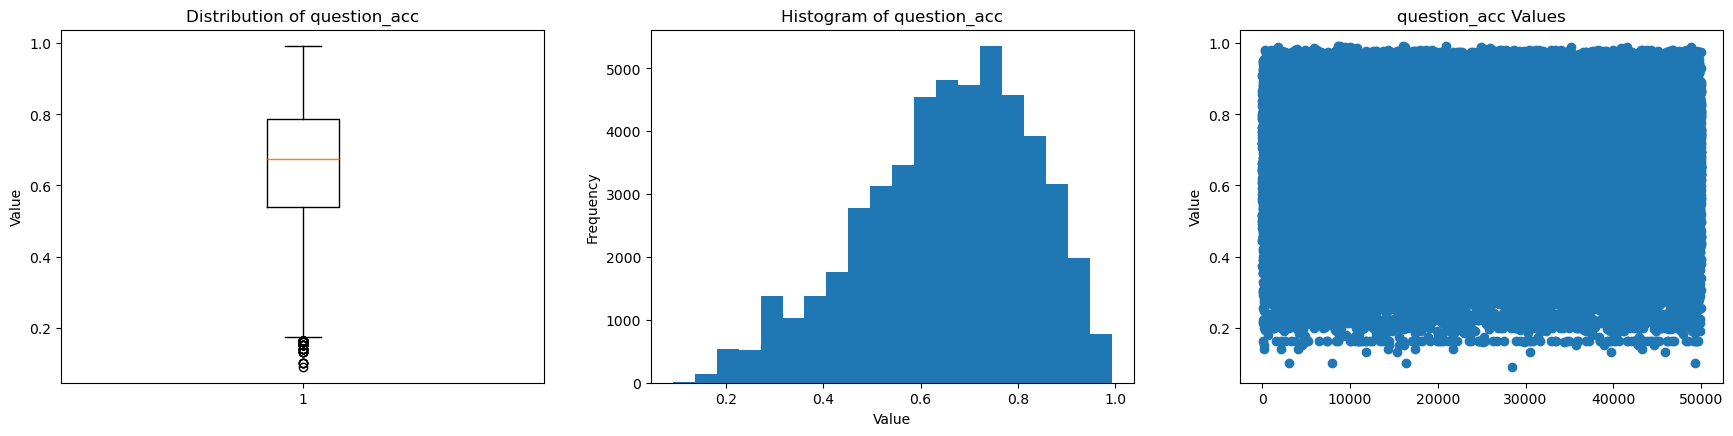

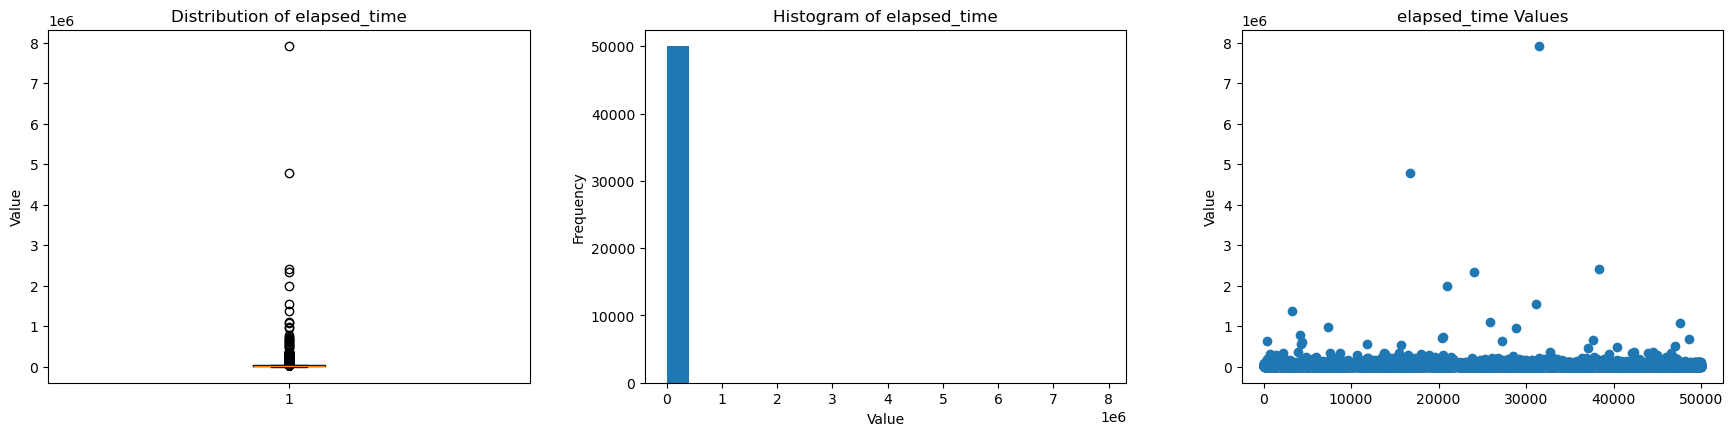

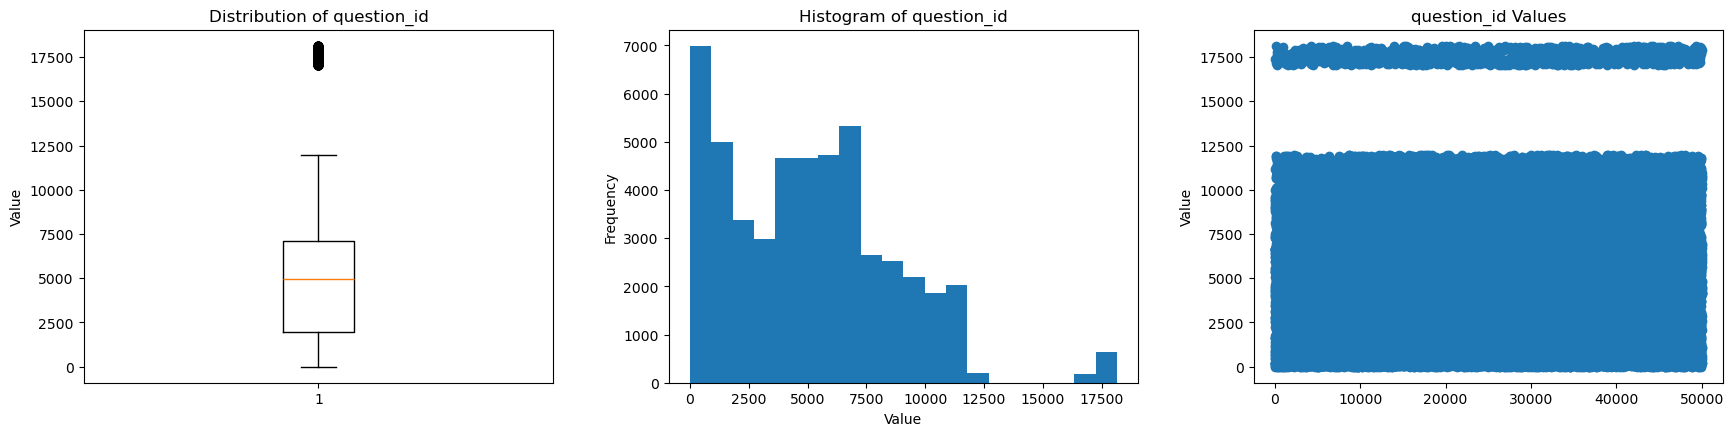

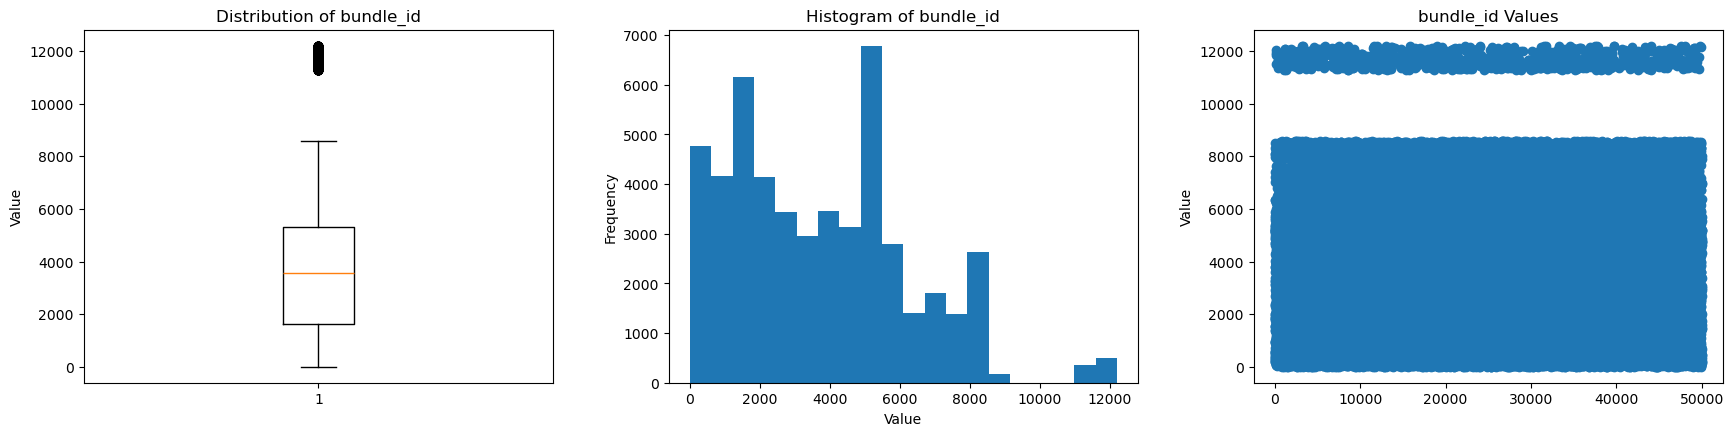

Standard Deviation of Question Accuracy: 0.1755
Standard Deviation of Elapsed Time: 51386.0630
Standard Deviation of Question_id: 3599.8343
Standard Deviation of Bundle_id: 2543.1681



In [11]:
quest_acc_sample = X_train['question_acc'].sample(n=50000)
elp_time_sample = X_train['elapsed_time'].sample(n=50000)
quest_id_sample = X_train['question_id'].sample(n=50000)
bundle_id_sample = X_train['bundle_id'].sample(n=50000)

std_dev_quest_acc = get_info(quest_acc_sample)
std_dev_elp_time = get_info(elp_time_sample)
std_dev_qest_id = get_info(quest_id_sample)
std_dev_bund_id = get_info(bundle_id_sample)
print(f"Standard Deviation of Question Accuracy: {std_dev_quest_acc:.4f}\n"
      f"Standard Deviation of Elapsed Time: {std_dev_elp_time:.4f}\n"
      f"Standard Deviation of Question_id: {std_dev_qest_id:.4f}\n"
      f"Standard Deviation of Bundle_id: {std_dev_bund_id:.4f}\n")

Data is normalized based off results of distribution displayed above
- question_id, elapsed_time, and bundle_id will all be normalized based off standard scalar due to their skewed distributions based of histogram chart
- elapsed_time will most likely require some more data trimming due to the large outliers displayed above
- possiblility that we might be able to remove question_id or bundle_id without effecting accuracy too much as well 

#### Training Logistic Model
Designed by Ben Belandres

In [9]:
norm_scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), ['elapsed_time', 'bayes_rolling_acc']),
        ('minmax', MinMaxScaler(), ['question_acc', 'num_interactions'])
    ]
)

pipe = make_pipeline(norm_scaler, LogisticRegression(max_iter=1000, random_state=865))
pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard', ...), ('minmax', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Model Results
Designed by Ben Belandres

In [10]:
# Predict on training set
y_hat = pipe.predict(X_train)
print(f"Model training accuracy is {accuracy_score(y_train, y_hat)*100:0.2f}%")
# Predict on validation set
y_hat = pipe.predict(X_val)
print(f"Model validation accuracy is {accuracy_score(y_val, y_hat)*100:0.2f}%")

Model training accuracy is 71.34%
Model validation accuracy is 71.26%
